In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from utilities import retrieve_data
from matplotlib.colors import ListedColormap, BoundaryNorm

ERA_VERSION = 'ERA5'  # One day this will change to ERA6

# ====================
# To get a CDS API key, sign up at https://cds.climate.copernicus.eu/
# It is free and easy! After registering, copy your "Personal Access Token here"
# ====================
KEY = '############################'
KEY = '6cc2b53b-e3c0-42fd-b7ad-db64aeeb5298'

# ====================
# Change these to plot different locations. You can see the currently used ones in the ERA Explorer URL
# ====================
lat = 50.86  # Default latitude
lng = 4.35  # Default longitude

# ====================
# These can be changed to get different data; leave them for now
# ====================
variable = "2m_temperature"
date_range = ["1940-01-01", "2023-12-31"]

# ====================
# Get the data. This will download a NetCDF file
# ====================
data_file = retrieve_data(KEY, variable, date_range, lat, lng)

{'variable': ['2m_temperature'], 'date': ['1940-01-01/2023-12-31'], 'location': {'longitude': 4.35, 'latitude': 50.86}, 'data_format': 'netcdf'}
2m_temperature_1940-01-01_2023-12-31_50.86_4.35.nc


2024-12-02 14:33:59,990 WARNING [2024-11-27T00:00:00] System is back on service under testing conditions. Please follow updates [here](https://forum.ecmwf.int/t/cds-ads-and-ewds-down-until-further-notice/8015) and status [here](https://status.ecmwf.int/)
2024-12-02 14:33:59,991 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-12-02 14:33:59,992 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-02 14:33:59,992 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-

Retrieving data in to:  2m_temperature_1940-01-01_2023-12-31_50.86_4.35.nc


In [3]:
# Make a function to compute the warming stripes
def warmingStripes():
    """
    Generates warming stripes data based on temperature anomalies.
    This function processes temperature data to generate warming stripes, which are visual representations of temperature anomalies over time. The data is normalized and resampled to annual means, and anomalies are calculated relative to a climatology period.
    Returns:
        tuple: A tuple containing:
            - years (list): List of years corresponding to the temperature data.
            - stripes_values (numpy.ndarray): Normalized temperature anomalies for each year.
    """

    clim_year_stripes_start = 1961
    clim_year_stripes_end = 2010

    norm_stripes_start = 1940
    norm_stripes_end = 1999

    climatology_period_stripes = slice('{:d}-01-01'.format(clim_year_stripes_start), '{:d}-12-31'.format(clim_year_stripes_end))
    normalisation_period_stripes = slice('{:d}-01-01'.format(norm_stripes_start), '{:d}-12-31'.format(norm_stripes_end))  # Not the same as the clim period

    data = xr.open_dataset(data_file)
    data_t2m_pt = data.t2m

    # Remove incomplete year
    current_year = datetime.now().year
    timestamp_string = '{:d}-12-31 00:00:00'.format(current_year - 1)
    cutoff_date = pd.Timestamp(timestamp_string)
    data_t2m_pt_trun = data_t2m_pt.sel(valid_time=slice(None, cutoff_date))

    # Resample the data to annual means
    data_t2m_pt_agg = data_t2m_pt_trun.resample(valid_time="YE").mean()
    years = data_t2m_pt_agg.valid_time.to_index().year.tolist()

    # Calculate the standard deviation for normalization
    data_t2m_pt_agg_std = data_t2m_pt_agg.sel(valid_time=normalisation_period_stripes).std()
    scaling = (data_t2m_pt_agg_std * 3.0)
    
    # Calculate climatology and anomalies
    data_t2m_pt_agg_clim1 = data_t2m_pt_agg.sel(valid_time=climatology_period_stripes).mean()
    data_t2m_pt_agg_anom1 = data_t2m_pt_agg - data_t2m_pt_agg_clim1
    data_t2m_pt_agg_anom_norm1 = data_t2m_pt_agg_anom1 / scaling
    stripes_values = data_t2m_pt_agg_anom_norm1.values

    return (years, stripes_values)

# Call our function
years1, ts1 = warmingStripes()

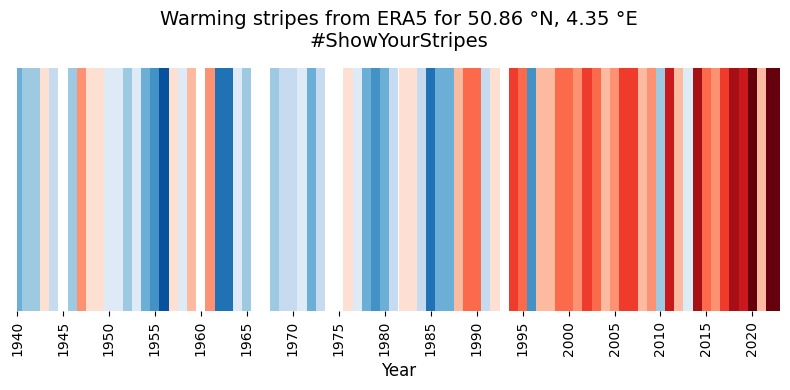

In [4]:
# Make the plot
lw = 2
marker = 'o'
markersize = 4

latSuffix = 'N' if lat > 0 else 'S'
lngSuffix = 'E' if lng > 0 else 'W'

# Custom stripe colors
stripeColorsWhiteCentre = [
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7', '#ffffff',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
]

# Define the range and colormap
vmin, vmax = -1, 1
cmap = ListedColormap(stripeColorsWhiteCentre)
norm = BoundaryNorm(
    boundaries=np.linspace(vmin - 0.01, vmax + 0.01, len(stripeColorsWhiteCentre) + 1),
    ncolors=len(stripeColorsWhiteCentre),
    clip=True
)

# Create a new figure
plt.figure(figsize=(8, 4))

# Map data to colors (clamping values outside [-1, 1])
colors = cmap(norm(np.clip(ts1, vmin, vmax)))

# Plot the data as bars
plt.bar(years1, height=1, width=1.0, color=colors, align='center', edgecolor='none')

# Customize the x-ticks to appear every 5 years
plt.xticks(np.arange(1940, 2100, 5), rotation=90)
plt.xlim(years1[0], years1[-1])

# Remove the y-axis ticks and labels for the #ShowYourStripes look
plt.gca().yaxis.set_visible(False)

# Add x-axis label and title
plt.xlabel('Year', fontsize=12)
plt.title(f'Warming stripes from {ERA_VERSION:s} for {abs(lat):.2f} °{latSuffix:s}, {abs(lng):.2f} °{lngSuffix:s}\n#ShowYourStripes', fontsize=14)

# Remove spines for a clean look
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()